# This notebook aims to detect duplicate reimbursements.

## To do so i took the following paper as base:
1) B. Wang, Z. Li, M. Li and W. y. Ma, "Large-Scale Duplicate Detection for Web Image Search," 2006 IEEE International Conference on Multimedia and Expo, Toronto, Ont., 2006, pp. 353-356.
doi: 10.1109/ICME.2006.262509
link: https://pdfs.semanticscholar.org/32fe/c74b6e319921672aa7f6ca2d2598bf92120d.pdf

They are generating hash code to detect duplicate image. Thus, i found some python libraries which do the same. 

Dash Python library to calculate the difference hash (perceptual hash) for a given image, useful for detecting duplicates. (https://github.com/Jetsetter/dhash)



# Necessary imports

In [1]:
# Detecting using hamming
from io import BytesIO
from urllib.request import urlopen
import dhash
from PIL import Image as pil_image
from wand.image import Image
from PIL import ImageFilter
import os

import scipy as sp
import numpy as np
from scipy.ndimage import zoom
import scipy.misc
from scipy.ndimage import rotate
from scipy.misc import face
from matplotlib import pyplot as plt

import imreg_dft as ird

# Function to download the pdf and convert it to PNG

In [2]:
def download_doc(url_link):
            try:
                # Open the resquest and get the file
                response = urlopen(url_link)
                # Default arguments to read the file and has a good resolution
                with Image(file=response, resolution=300) as img:
                    img.compression_quality = 99
                    # Chosen format to convert pdf to image
                    with img.convert('png') as converted:
                        # Converts the Wand image to PIL image
                        data = pil_image.open(BytesIO(converted.make_blob()))
                        data = data.convert('RGB')
                        hw_tuple = (800,600)
                        # Resizing of PIL image to fit our ML model
                        if data.size != hw_tuple:
                            data = data.resize(hw_tuple)
                        return data
            except Exception as ex:
                print("Error during pdf download")
                print(ex)
                # Case we get some exception we return None
                return None

def hamming2(s1, s2):
    """Calculate the Hamming distance between two bit strings"""
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def clipped_zoom(img, zoom_factor, **kwargs):
    " Zoom in or zoom out an informed image"
    h, w = img.shape[:2]

    # width and height of the zoomed image
    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))

    # for multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # zooming out
    if zoom_factor < 1:
        # bounding box of the clip region within the output array
        top = (h - zh) // 2
        left = (w - zw) // 2
        # zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # zooming in
    elif zoom_factor > 1:
        # bounding box of the clip region within the input array
        top = (zh - h) // 2
        left = (zw - w) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # if zoom_factor == 1, just return the input array
    else:
        out = img
    return out


# Duplicated Reimbursement

As duplicate i'm applying a BLUR filter in the downloaded reimbursement. Therefore, the reimbursement is the same, but with different image resolution!


In [3]:
doc1 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/2437/2015/5645173.pdf'

In [4]:
# Original
image1 = download_doc(doc1)

# Duplicate
image2 = image1.filter(ImageFilter.BLUR)

# Detection!

In [5]:
dhash.force_pil()

size = 8

row, col = dhash.dhash_row_col(image1)
hash1 = dhash.format_hex(row, col,size=size)
print(hash1)
row, col = dhash.dhash_row_col(image2)
hash2 = dhash.format_hex(row, col,size=size)
print(hash2)
num_bits_different = hamming2(hash1, hash2)
print(num_bits_different)
print('{} {} out of {} ({:.1f}%)'.format(
                num_bits_different,
                'bit differs' if num_bits_different == 1 else 'bits differ',
                size * size * 2,
                100 * num_bits_different / (size * size * 2)))

20181c1c18000000c7000c7c38000000
30181c1c18000000c7000c7c38000000
1
1 bit differs out of 128 (0.8%)


# Using documents which looks close, however they are different!

document_ids: 5886345 and 5886361.

In [6]:
doc1 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/3074/2015/5886345.pdf'
doc2 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/3074/2015/5886361.pdf'

In [7]:
image1 = download_doc(doc1)
image2 = download_doc(doc2)

# Detection!

In [8]:
dhash.force_pil()

size = 8

row, col = dhash.dhash_row_col(image1)
hash1 = dhash.format_hex(row, col,size=size)
print(hash1)
row, col = dhash.dhash_row_col(image2)
hash2 = dhash.format_hex(row, col,size=size)
print(hash2)
num_bits_different = hamming2(hash1, hash2)
print(num_bits_different)
print('{} {} out of {} ({:.1f}%)'.format(
                num_bits_different,
                'bit differs' if num_bits_different == 1 else 'bits differ',
                size * size * 2,
                100 * num_bits_different / (size * size * 2)))

d93bdbd71e787a009020fbdf0688fa00
6666462f3f060e0af0ec06f879167e08
29
29 bits differ out of 128 (22.7%)


# Conclusion 

I’ve found that the dhash is great for detecting near duplicates (using a size 8 dhash with a maximum delta of 2 bits). But because of the simplicity of the algorithm, it’s not great at finding similar images or duplicate-but-cropped images – you’d need a more sophisticated image fingerprint if you want that. However, the dhash is good for finding exact duplicates and near duplicates, for example, the same image with slightly altered lighting, a few pixels of cropping, or very light photoshopping.

# Future direction

I suggest to take a look in the follwing paper:
    
Pratim Ghosh, E. Drelie Gelasca, K.R. Ramakrisnan and B.S. Manjunath,
“Duplicate Image Detection in Large Scale Databases”,
Book Chapter in Platinum Jubilee Volume, Indian Statistical Institute, Kolkata, Oct. 2007.
    
https://vision.ece.ucsb.edu/sites/vision.ece.ucsb.edu/files/publications/pratim_2007_book.pdf

They are using Fourier transformation to detect duplicates. 

In the same direction, i tried to find a python project that has it.
Take a look in this one: https://github.com/matejak/imreg_dft

# Using discrete Fourier transform to detect duplicates 

### Bellow i used the first example of this notebook
** It is the application of the filter BLUR over the image. (Therefore, we have the same reimbursement, but with different resolution) **

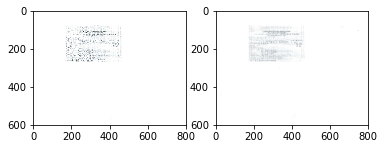

In [9]:
basedir = os.path.join('../research/data/')

# the TEMPLATE
doc1 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/2437/2015/5645173.pdf'

# Original
image1 = download_doc(doc1)
image1.save(os.path.join(basedir,"sample1"), "png")

# Duplicate
image2 = image1.filter(ImageFilter.BLUR)
image2.save(os.path.join(basedir,"sample2"), "png")

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image1)
ax[1].imshow(image2)



In [10]:
im1 = sp.misc.imread(os.path.join(basedir, "sample1"), True)
im2 = sp.misc.imread(os.path.join(basedir, "sample2"), True)

result = ird.similarity(im1, im2, numiter=3)
print (result["success"])

/opt/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0.56011238357


The rate of success means the proportion which the two images are aligned.

# Now I'm rotaing the above reimbursement in 30 degress.

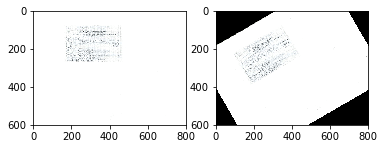

In [11]:
basedir = os.path.join('../research/data/')

# the TEMPLATE
doc1 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/2437/2015/5645173.pdf'

# Original
image1 = download_doc(doc1)
image1.save(os.path.join(basedir,"sample1"), "png")

# Duplicate
rot = image1.rotate(30)
rot.save(os.path.join(basedir,"sample2"), "png")

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image1)
ax[1].imshow(rot)



In [12]:
im1 = sp.misc.imread(os.path.join(basedir, "sample1"), True)
im2 = sp.misc.imread(os.path.join(basedir, "sample2"), True)

result = ird.similarity(im1, im2, numiter=3)
print (result["success"])

/opt/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0.771001340843


For the rotation the rate is very strong!

# The next cell works with images of different zoom 

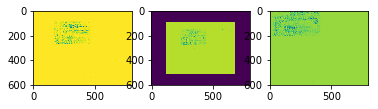

In [13]:
basedir = os.path.join('../research/data/')

# the TEMPLATE
doc1 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/2437/2015/5645173.pdf'
# Original
image1 = download_doc(doc1)
image1.save(os.path.join(basedir,"sample1"), "png")
img = sp.misc.imread(os.path.join(basedir, "sample1"), True)

zm1 = clipped_zoom(img, 0.7) # Zoom out of 30%
zm2 = clipped_zoom(img, 1.3) # Zoom in of 30%

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[1].imshow(zm1)
ax[2].imshow(zm2)

In [14]:

#Duplicate
result = ird.similarity(im1, zm1, numiter=3)
print (result["success"])

result = ird.similarity(im1, zm2, numiter=3)
print (result["success"])

/opt/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0.739999941154
1.13653940352


For the zoom the rate is very strong!

# Finally the different reimbursement

In [15]:
basedir = os.path.join('../research/data/')

# the TEMPLATE
doc1 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/3074/2015/5886345.pdf'
doc2 = 'http://www.camara.gov.br/cota-parlamentar/documentos/publ/3074/2015/5886361.pdf'


image1 = download_doc(doc1)
image2 = download_doc(doc2)

# Original
image1.save(os.path.join(basedir,"sample1"), "png")

# Duplicate
image2.save(os.path.join(basedir,"sample2"), "png")

im1 = sp.misc.imread(os.path.join(basedir, "sample1"), True)
im2 = sp.misc.imread(os.path.join(basedir, "sample2"), True)

result = ird.similarity(im1, im2, numiter=3)
print (result["success"])

/opt/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0.0169975024018


# Conclusion

# The combination of the both methods, hash and Fourier can provide good results to detect duplicates
